In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
from os import listdir
from os.path import exists
import time

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn import manifold, decomposition

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import *

In [3]:
import cv2

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Model
# Utilisation d'autre chose que VGG16 car trop lent et surdimensionné pour nous
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.applications.densenet import DenseNet121 as MobileNetV2
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing.image import load_img

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from plot_keras_history import show_history, plot_history

# Récupération des données

In [7]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [8]:
data = pd.read_csv(path_csv)

## Mise en forme et quelques stats

### Gestion de l'arbre de catégories

In [9]:
# Récupère le noeud à la profondeur "level"
# (ou la feuille si level va trop profond)
# (ou la racine si level remonte trop)
def get_from_tree(tree, level):
    if len(tree) > level and len(tree) >= -level:
        return tree[level]
    elif len(tree) < -level:
        return tree[0]
    else:
        return tree[-1]

In [10]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [11]:
print("Nombre total de catégories possible (en comptant noeuds et feuilles) :")
print(len(data['product_category_list'].explode().unique()))

Nombre total de catégories possible (en comptant noeuds et feuilles) :
1126


In [12]:
print("Nombre total de catégories (feuilles) :")
print(len(data['product_category_tree'].unique()))

Nombre total de catégories (feuilles) :
642


In [13]:
tmp = data['product_category_list'].str.len()
print("Taille minimum d'une branche :", tmp.min())
print("Taille maximum d'une branche :", tmp.max())

Taille minimum d'une branche : 2
Taille maximum d'une branche : 7


Observation des catégories récupérées selon le niveau choisi :

In [14]:
level = 1

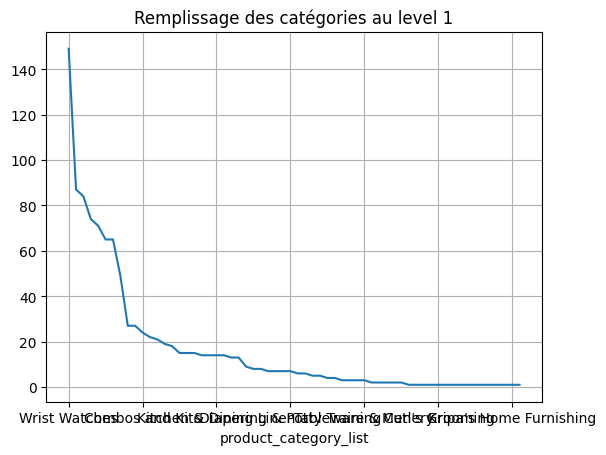

In [15]:
tmp = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))
ax = tmp.value_counts().plot(grid=True, title="Remplissage des catégories au level "+str(level))

In [16]:
level = -1

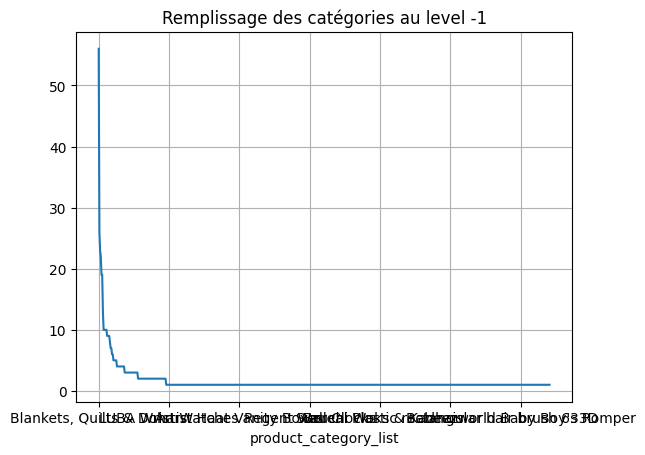

In [17]:
tmp = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))
ax = tmp.value_counts().plot(grid=True, title="Remplissage des catégories au level "+str(level))

Visualisation de l'arbre

In [18]:
import graphviz

In [19]:
dot = graphviz.Digraph()

lien_deja = set()

# Ajouter la racine de l'arbre
dot.node('Racine')

for n in data['product_category_list'].explode().unique():
    dot.node(n)

def ajouter_lien(precedent, actuel, suite):
    nom = "{}/{}".format(precedent, actuel)
    if nom not in lien_deja:
        dot.edge(precedent, actuel)
        lien_deja.add(nom)
    
    if len(suite) > 0 :
        ajouter_lien(actuel, suite[0], suite[1:])

for l in data['product_category_list']:
    ajouter_lien('Racine', l[0], l[1:])

# Affichage l'arbre
# dot.render('categories', view=True)

#### Choix du niveau de catégorie classique

In [20]:
level = 0

In [21]:
data['cat_group'] = data['product_category_list'].apply(lambda tree : get_from_tree(tree, level))

#### Version personalisée des catégories

In [22]:
# Nombre minimum d'éléments pour faire une catégorie
nb_min_elements = 30

In [23]:
index = -1

In [24]:
# Initialisation des données
tmp = data[['product_category_list']].copy()
tmp.columns = ['list']
tmp['actual'] = tmp['list'].apply(lambda tree : get_from_tree(tree, index))
tmp

,list,actual
0,"[Home Furnishing, Curtains & Accessories, Curt...",Elegance Polyester Multicolor Abstract Eyelet ...
1,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...","Sathiyas Cotton Bath Towel (3 Bath Towel, Red,..."
2,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Eurospa Cotton Terry Face Towel Set (20 PIECE ...
3,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",SANTOSH ROYAL FASHION Cotton Printed King size...
4,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Jaipur Print Cotton Floral King sized Double B...
...,...,...
1045,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Oren Empower Stickers
1046,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Stickers
1047,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Uberlyfe Stickers
1048,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Stickers


Application de l'algo : On part des feuilles de l'arbre, et tant qu'il n'y a pas assez l'éléments dans la catégorie on les remonte d'un niveau

In [25]:
old_unique = 0

In [26]:
while old_unique != len(tmp['actual'].unique()):
    old_unique = len(tmp['actual'].unique())
    index -= 1
    tmp_actual = tmp.groupby('actual').count()
    tmp_actual = tmp_actual.loc[tmp_actual['list']<nb_min_elements]
    
    mask = tmp['actual'].isin(tmp_actual.index)
    
    tmp.loc[mask, 'actual'] = tmp.loc[mask, 'list'].apply(lambda tree : get_from_tree(tree, index))

In [27]:
# Modification pour éviter une catégorie qui se retrouve seule sinon
tmp.loc[tmp['actual']=="Wrist Watches", 'actual'] = "Watches"

In [28]:
data['cat_group'] = tmp['actual']

### Finalisation mise en forme

In [29]:
data['cat_group'].value_counts()

cat_group
Watches                       150
Baby Care                     110
Home Furnishing                93
Beauty and Personal Care       86
Kitchen & Dining               76
Coffee Mugs                    74
Combos                         64
Computers                      63
Showpieces                     60
Blankets, Quilts & Dohars      57
Home Decor & Festive Needs     56
Routers                        49
Baby Girls' Clothes            40
USB Gadgets                    38
Ethnic                         34
Name: count, dtype: int64

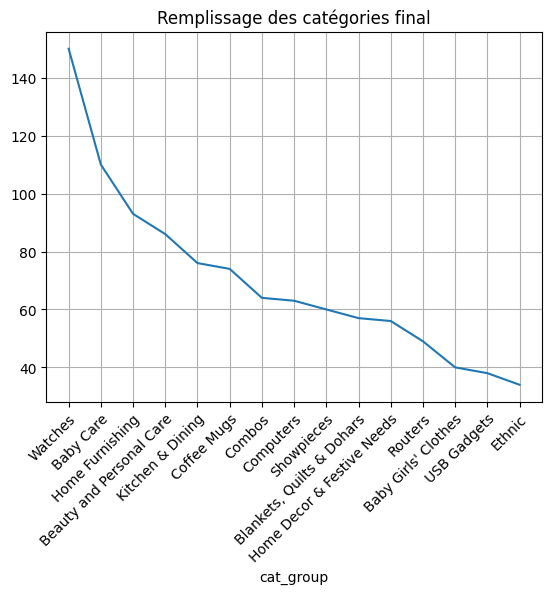

In [30]:
df = data['cat_group'].value_counts()
ax = df.plot.line(grid=True, title="Remplissage des catégories final")

ax.set_xticks(range(len(df.index)), list(df.index), rotation=45, ha='right', rotation_mode='anchor')
pass

In [31]:
# Nombre minimum d'éléments pour garder cette catégorie
nb_min_elements = 3

Mise en forme

In [32]:
data_final = data[['image', 'product_category_list', 'cat_group']].copy()
data_final.columns = ['img', 'cat_lst', 'cat']
data_final['img'] = path_img+'/'+data_final['img']

Conversion des labels

In [33]:
list_labels = list(data_final['cat'].value_counts().index)
data_final['label'] = data_final['cat'].apply(lambda e : list_labels.index(e))

Récupération d'infos et suppression des lignes avec des catégories trop vides

In [34]:
nb_cat_little = (data_final['cat'].value_counts() > nb_min_elements).sum()
nb_cat = len(list_labels)

In [35]:
print("Nombre de catégories total :", nb_cat)
print("Nombre de catégories de plus de", nb_min_elements, "élément :", nb_cat_little)

Nombre de catégories total : 15
Nombre de catégories de plus de 3 élément : 15


In [36]:
data_little = data_final.loc[data_final['cat'].isin(list_labels[:nb_cat_little])].copy().reset_index(drop=True)

In [37]:
data_little

,img,cat_lst,cat,label
0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,"[Home Furnishing, Curtains & Accessories, Curt...",Home Furnishing,2
1,./data/Flipkart/Images/7b72c92c2f6c40268628ec5...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,1
2,./data/Flipkart/Images/64d5d4a258243731dc7bbb1...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Baby Care,1
3,./data/Flipkart/Images/d4684dcdc759dd9cdf41504...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Home Furnishing,2
4,./data/Flipkart/Images/6325b6870c54cd47be6ebfb...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Home Furnishing,2
...,...,...,...,...
1045,./data/Flipkart/Images/958f54f4c46b53c8a0a9b81...,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Baby Care,1
1046,./data/Flipkart/Images/fd6cbcc22efb6b761bd564c...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,1
1047,./data/Flipkart/Images/5912e037d12774bb73a2048...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Baby Care,1
1048,./data/Flipkart/Images/c3edc504d1b4f0ba6224fa5...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Baby Care,1


Export du dataset

In [38]:
data_little.to_csv("./data/data_little.csv", index=False)

# Classification via MobileNetV2

In [39]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [40]:
def compare_clustering(original, predict, return_cat=False):
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

In [41]:
# Représentation des vecteurs et catégories en 2D
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat_little), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

In [42]:
def cat_to_label(l):
    return np.argmax(l)

## Initialisation du modèle

In [43]:
#from tensorflow.keras.applications.efficientnet import EfficientNetB0 as MobileNetV2
#from tensorflow.keras.applications.efficientnet import preprocess_input

In [44]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [45]:
input_shape = MobileNetV2().input_shape
input_shape

(None, 224, 224, 3)

Chargement du modèle en figeant toutes les couches sauf les dernières (celles de classification)

In [46]:
base_model = MobileNetV2(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [47]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

Ajout des dernières couches pour la prédiction addapté à nos targets

In [48]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 150)               9408150   
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                9060      
                                                                 
 dense_2 (Dense)             (None, 15)                915       
                                                        

## Chargment des images

In [50]:
# Conversion des images aux bonnes dimensions et format 
def preprocess_image(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    image = preprocess_input(image)
    return image

Chargement et conversion de toutes les images du dataset

In [51]:
data_X = list(data_little["img"].apply(preprocess_image))
data_X = np.asarray(data_X).astype(np.float32)

Conversion des targets

In [52]:
data_y = to_categorical(data_little['label'], num_classes=nb_cat_little)

Création des sets d'entrainement et de test

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, stratify=data_y, random_state=42)

## Classification

In [54]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.005, mode='max', patience=6, restore_best_weights=True)
#es = EarlyStopping(monitor='val_loss', min_delta = 0.002, mode='min', patience=6, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/30
16/16 [==============================] - 22s 1s/step - loss: 4.7377 - accuracy: 0.3862 - val_loss: 2.6134 - val_accuracy: 0.5261
Epoch 2/30
16/16 [==============================] - 18s 1s/step - loss: 1.2545 - accuracy: 0.7541 - val_loss: 2.1292 - val_accuracy: 0.5545
Epoch 3/30
16/16 [==============================] - 19s 1s/step - loss: 0.7453 - accuracy: 0.8252 - val_loss: 1.8475 - val_accuracy: 0.6066
Epoch 4/30
16/16 [==============================] - 19s 1s/step - loss: 0.4589 - accuracy: 0.8882 - val_loss: 2.0519 - val_accuracy: 0.6398
Epoch 5/30
16/16 [==============================] - 19s 1s/step - loss: 0.2715 - accuracy: 0.9187 - val_loss: 2.4362 - val_accuracy: 0.6256
Epoch 6/30
16/16 [==============================] - 18s 1s/step - loss: 0.2819 - accuracy: 0.9492 - val_loss: 2.4025 - val_accuracy: 0.5735
Epoch 7/30
16/16 [==============================] - 19s 1s/step - loss: 0.1877 - accuracy: 0.9451 - val_loss: 2.6251 - val_accuracy: 0.5924
Epoch 8/30
16/16 [==

## Résultats

In [55]:
def evaluate_model(model, X, y):
    start = time.time()
    y_pred = model.predict(X)
    enlapsed = time.time() - start

    print()
    print("Temps de prédiction (en s): ", round(enlapsed, 2))
    print("Nombre de valeurs à prédire : ", len(X))
    print("Temps moyen par prédiction (en ms): ", int(1000 * enlapsed/len(X)))
    
    y_label = [cat_to_label(e) for e in y]
    y_pred_label = [cat_to_label(e) for e in y_pred]
    
    print()
    print("Accuracy score (taux de classes correctements prédites) sur le set de test :")
    print(accuracy_score(y_label, y_pred_label))
    
    #print()
    #print("Accuracy score (taux de classes présentes dans le top 2) sur le set de test :")
    #print(top_k_accuracy_score(y_label, y_pred, k=2))

    print()
    print("Score de Cohen kappa sur le set de test :")
    print(cohen_kappa_score(y_label, y_pred_label))

    print()
    print("Coefficient de corrélation de Matthews sur le set de test :")
    print(matthews_corrcoef(y_label, y_pred_label))
    
    return y_label, y_pred_label, y_pred

In [56]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 10s 796ms/step

Temps de prédiction (en s):  9.82
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  28

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.6743515850144092

Score de Cohen kappa sur le set de test :
0.6463622507417996

Coefficient de corrélation de Matthews sur le set de test :
0.6512171446144867


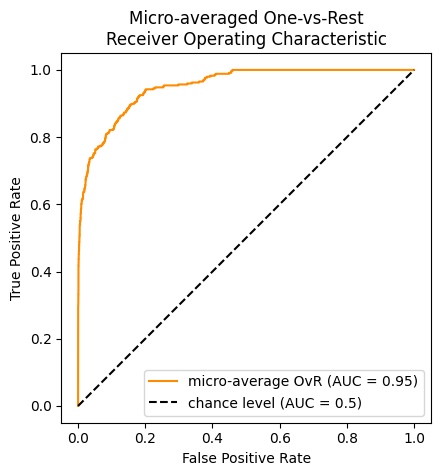

In [57]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Résultats au cas pas cas

In [58]:
labels_little = data_little.sort_values('label')['cat'].unique()

In [59]:
print(classification_report(
    y_test_label,
    pred_test_label,
    target_names=labels_little,
    zero_division=0))

                            precision    recall  f1-score   support

                   Watches       0.96      0.96      0.96        50
                 Baby Care       0.56      0.42      0.48        36
           Home Furnishing       0.43      0.81      0.56        31
  Beauty and Personal Care       0.66      0.68      0.67        28
          Kitchen & Dining       0.94      0.64      0.76        25
               Coffee Mugs       0.96      1.00      0.98        24
                    Combos       0.91      1.00      0.95        21
                 Computers       0.55      0.76      0.64        21
                Showpieces       0.40      0.10      0.16        20
 Blankets, Quilts & Dohars       0.62      0.68      0.65        19
Home Decor & Festive Needs       0.00      0.00      0.00        19
                   Routers       0.87      0.81      0.84        16
       Baby Girls' Clothes       0.82      0.69      0.75        13
               USB Gadgets       0.89      0.62

In [60]:
list_labels = data_little.sort_values('label')['cat'].unique()

In [61]:
compare_clustering([list_labels[i] for i in y_test_label], pred_test_label)

,pred_0,pred_2,pred_5,pred_6,pred_3,pred_7,pred_4,pred_1,pred_9,pred_11,pred_14,pred_12,pred_13,pred_8,pred_10
cat,,,,,,,,,,,,,,,
Watches,48,0,0,0,1,0,0,0,0,0,1,0,0,0,0
Home Furnishing,0,25,0,0,0,1,0,2,3,0,0,0,0,0,0
Coffee Mugs,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0
Combos,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0
Beauty and Personal Care,0,2,0,2,19,0,0,3,1,0,0,0,1,0,0
Computers,0,0,0,0,2,16,0,0,1,2,0,0,0,0,0
Kitchen & Dining,0,2,0,0,2,3,16,1,0,0,0,0,0,0,1
Baby Care,0,14,0,0,1,0,1,15,1,0,1,2,0,0,1
"Blankets, Quilts & Dohars",0,3,0,0,0,0,0,2,13,0,1,0,0,0,0


Evolution de l'apprentissage

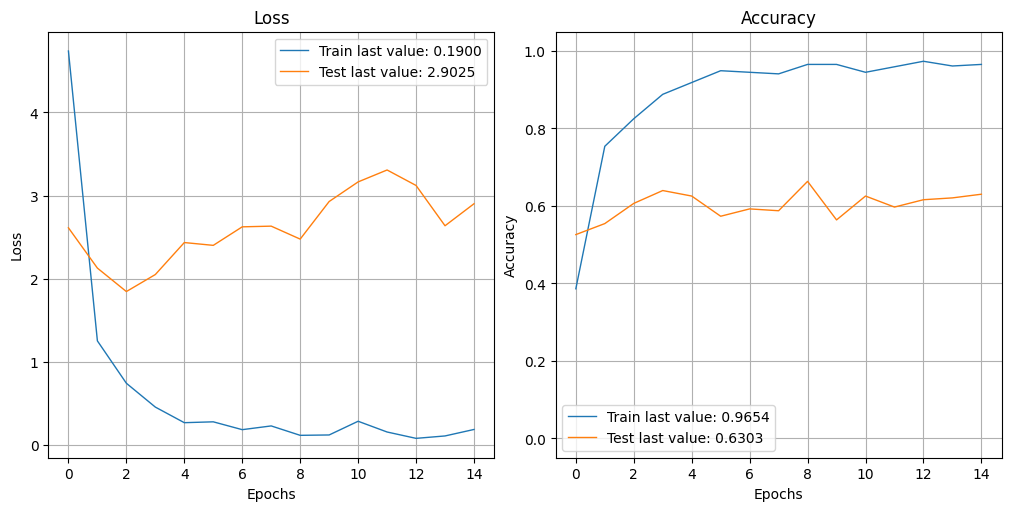

In [62]:
show_history(history)
plt.close()

# Model DIY

In [63]:
from tensorflow import keras

In [64]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(3, 6, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)
    x = layers.Conv2D(6, 16, strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)
    x = layers.Conv2D(6*6, 32, strides=2, padding="same")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(32*5*5, activation='relu')(x)
    x = layers.Dense(16*5*5, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(120, activation='relu')(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape[1:3] + (3,), num_classes=nb_cat_little)

In [65]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 3)       327       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 6)         4614      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                         

In [66]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

es = EarlyStopping(monitor='val_accuracy', min_delta = 0.005, mode='max', patience=6, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/20
16/16 [==============================] - 6s 326ms/step - loss: 2.6655 - accuracy: 0.1280 - val_loss: 2.5929 - val_accuracy: 0.1848
Epoch 2/20
16/16 [==============================] - 5s 319ms/step - loss: 2.5391 - accuracy: 0.1809 - val_loss: 2.5169 - val_accuracy: 0.2227
Epoch 3/20
16/16 [==============================] - 5s 338ms/step - loss: 2.3805 - accuracy: 0.2398 - val_loss: 2.4007 - val_accuracy: 0.2654
Epoch 4/20
16/16 [==============================] - 5s 311ms/step - loss: 2.2013 - accuracy: 0.3150 - val_loss: 2.2346 - val_accuracy: 0.3365
Epoch 5/20
16/16 [==============================] - 5s 314ms/step - loss: 1.9805 - accuracy: 0.3679 - val_loss: 2.2906 - val_accuracy: 0.3365
Epoch 6/20
16/16 [==============================] - 5s 313ms/step - loss: 1.8630 - accuracy: 0.4228 - val_loss: 2.1487 - val_accuracy: 0.3223
Epoch 7/20
16/16 [==============================] - 5s 313ms/step - loss: 1.7744 - accuracy: 0.4167 - val_loss: 2.1411 - val_accuracy: 0.3791
Epoch 

In [67]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 1s 89ms/step

Temps de prédiction (en s):  1.15
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  3

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.40634005763688763

Score de Cohen kappa sur le set de test :
0.3484577803704243

Coefficient de corrélation de Matthews sur le set de test :
0.3525463401650381


In [68]:
compare_clustering([list_labels[i] for i in y_test_label], pred_test_label)

,pred_0,pred_5,pred_6,pred_7,pred_2,pred_1,pred_8,pred_11,pred_3,pred_4,pred_9,pred_10,pred_13,pred_12,pred_14
cat,,,,,,,,,,,,,,,
Watches,43,1,0,1,1,1,0,0,1,1,0,1,0,0,0
Coffee Mugs,1,22,0,0,0,0,0,0,0,0,0,0,0,1,0
Combos,0,0,17,1,2,0,0,0,0,1,0,0,0,0,0
Computers,1,0,0,11,2,1,0,0,2,1,1,2,0,0,0
Home Furnishing,3,0,5,1,11,1,3,0,2,0,3,1,0,1,0
Baby Care,6,1,1,0,7,10,5,2,1,0,2,1,0,0,0
Baby Girls' Clothes,1,0,0,1,0,1,8,1,1,0,0,0,0,0,0
Routers,1,0,2,0,0,2,0,6,1,4,0,0,0,0,0
Showpieces,3,0,1,0,2,0,7,0,5,0,0,1,0,0,1


# VGG16

In [69]:
from tensorflow.keras.applications.vgg16 import VGG16 as VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

Chargement du modèle en figeant toutes les couches sauf les dernières (celles de classification)

In [70]:
base_model = VGG16(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [71]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Ajout des dernières couches pour la prédiction addapté à nos targets

In [72]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 150)               3763350   
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_8 (Dense)             (None, 60)                9060      
                                                                 
 dense_9 (Dense)             (None, 15)                915       
                                                                 
Total params: 18,488,013
Trainable params: 3,773,325
N

In [74]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.005, mode='max', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/30
16/16 [==============================] - 162s 10s/step - loss: 2.3674 - accuracy: 0.2988 - val_loss: 1.6660 - val_accuracy: 0.4550
Epoch 2/30
16/16 [==============================] - 162s 10s/step - loss: 1.0868 - accuracy: 0.6667 - val_loss: 1.3699 - val_accuracy: 0.5592
Epoch 3/30
16/16 [==============================] - 161s 10s/step - loss: 0.5859 - accuracy: 0.8069 - val_loss: 1.2636 - val_accuracy: 0.6398
Epoch 4/30
16/16 [==============================] - 180s 12s/step - loss: 0.3236 - accuracy: 0.9106 - val_loss: 1.3196 - val_accuracy: 0.6161
Epoch 5/30
16/16 [==============================] - 161s 10s/step - loss: 0.2221 - accuracy: 0.9329 - val_loss: 1.2944 - val_accuracy: 0.6256
Epoch 6/30
16/16 [==============================] - 163s 10s/step - loss: 0.1311 - accuracy: 0.9715 - val_loss: 1.3086 - val_accuracy: 0.6398


In [75]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 80s 7s/step

Temps de prédiction (en s):  79.9
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  230

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.6340057636887608

Score de Cohen kappa sur le set de test :
0.601528098015281

Coefficient de corrélation de Matthews sur le set de test :
0.6038746955765814


In [76]:
compare_clustering([list_labels[i] for i in y_test_label], pred_test_label)

,pred_0,pred_5,pred_6,pred_2,pred_4,pred_1,pred_3,pred_12,pred_7,pred_11,pred_9,pred_13,pred_8,pred_10,pred_14
cat,,,,,,,,,,,,,,,
Watches,46,0,0,0,2,0,1,0,0,0,0,1,0,0,0
Coffee Mugs,0,23,0,0,1,0,0,0,0,0,0,0,0,0,0
Combos,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0
Home Furnishing,1,0,0,21,0,7,0,1,0,0,1,0,0,0,0
Kitchen & Dining,1,0,0,0,18,4,1,0,0,0,0,1,0,0,0
Baby Care,0,0,0,4,6,17,2,5,0,0,1,0,0,0,1
Beauty and Personal Care,1,0,2,0,3,4,15,0,0,0,0,3,0,0,0
Baby Girls' Clothes,0,0,0,0,1,1,0,11,0,0,0,0,0,0,0
Computers,1,0,0,0,2,0,4,0,10,1,0,0,2,1,0


# Xception

In [77]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [78]:
base_model = Xception(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [79]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

Ajout des dernières couches pour la prédiction addapté à nos targets

In [80]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 150)               15052950  
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_11 (Dense)            (None, 60)                9060      
                                                                 
 dense_12 (Dense)            (None, 15)                915       
                                                                 
Total params: 35,924,405
Trainable params: 15,062,925


In [82]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.005, mode='max', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.3, batch_size=32, callbacks=[es])

Epoch 1/30
16/16 [==============================] - 76s 5s/step - loss: 7.1747 - accuracy: 0.3476 - val_loss: 2.5394 - val_accuracy: 0.5403
Epoch 2/30
16/16 [==============================] - 70s 4s/step - loss: 1.9290 - accuracy: 0.6423 - val_loss: 1.9165 - val_accuracy: 0.5545
Epoch 3/30
16/16 [==============================] - 77s 5s/step - loss: 1.0019 - accuracy: 0.7419 - val_loss: 1.5062 - val_accuracy: 0.5782
Epoch 4/30
16/16 [==============================] - 77s 5s/step - loss: 0.6435 - accuracy: 0.8293 - val_loss: 1.3588 - val_accuracy: 0.6209
Epoch 5/30
16/16 [==============================] - 71s 4s/step - loss: 0.4344 - accuracy: 0.8720 - val_loss: 1.7496 - val_accuracy: 0.5877
Epoch 6/30
16/16 [==============================] - 70s 4s/step - loss: 0.4413 - accuracy: 0.8740 - val_loss: 1.2768 - val_accuracy: 0.6682
Epoch 7/30
16/16 [==============================] - 71s 5s/step - loss: 0.1871 - accuracy: 0.9411 - val_loss: 1.3925 - val_accuracy: 0.7109
Epoch 8/30
16/16 [==

In [83]:
y_test_label, pred_test_label, pred_test = evaluate_model(model, X_test, y_test)

11/11 [==============================] - 35s 3s/step

Temps de prédiction (en s):  34.91
Nombre de valeurs à prédire :  347
Temps moyen par prédiction (en ms):  100

Accuracy score (taux de classes correctements prédites) sur le set de test :
0.7118155619596542

Score de Cohen kappa sur le set de test :
0.6860921640643376

Coefficient de corrélation de Matthews sur le set de test :
0.6878477433238726


In [84]:
compare_clustering([list_labels[i] for i in y_test_label], pred_test_label)

,pred_0,pred_2,pred_5,pred_6,pred_4,pred_3,pred_7,pred_1,pred_9,pred_11,pred_8,pred_10,pred_12,pred_13,pred_14
cat,,,,,,,,,,,,,,,
Watches,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Home Furnishing,0,28,0,0,0,0,1,1,1,0,0,0,0,0,0
Coffee Mugs,0,0,22,0,2,0,0,0,0,0,0,0,0,0,0
Combos,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0
Kitchen & Dining,0,0,0,0,21,1,1,1,0,0,0,0,0,0,1
Beauty and Personal Care,1,1,0,0,1,18,0,4,0,0,0,1,0,2,0
Computers,0,1,0,0,0,0,16,1,0,1,0,1,0,1,0
Baby Care,0,7,0,1,4,0,1,15,2,0,1,2,3,0,0
"Blankets, Quilts & Dohars",0,3,0,0,1,1,1,0,13,0,0,0,0,0,0
